### Предварительная предобработка изображений и распознавание номеров на реальных данных
* Источник для алгоритма предобработки коротких номеров:

 https://pyimagesearch.com/2021/11/22/improving-ocr-results-with-basic-image-processing/

In [1]:
%%capture
!pip install opencv-python # *not* opencv-contrib-python
# !pip install jiwer
!apt install tesseract-ocr
!pip install pytesseract

In [2]:
import os
import cv2
import imutils
import numpy as np
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

### Две функции распознавания:
* Для длинных номеров (номер бюллетеня)
* Для коротких номеров (номер страницы)

In [8]:
# функция распознавания длинных номеров
def recognize_long_number(im):

  corrected = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  res = pytesseract.image_to_string(corrected, lang='eng', config='--psm 6 -c tessedit_char_whitelist=0123456789/- ').replace('\n\x0c', '')
  res = res.strip()
  str_parts = res.split('/')
  if len(str_parts)>1:
    part1 = str_parts[0][-23:]
    part2 = str_parts[1]
    res = part1+'/'+part2

  return res

In [4]:
# функция распознавания коротких номеров
def recognize_short_number(im):

  corrected = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  corrected = cv2.threshold(corrected, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  dist = cv2.distanceTransform(corrected, cv2.DIST_L2, 5)
  dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
  dist = (dist * 255).astype("uint8")
  dist = cv2.threshold(dist, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

  cnts = cv2.findContours(dist.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  chars = []

  for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    chars.append(c)


  chars = np.vstack([chars[i] for i in range(0, len(chars))])
  hull = cv2.convexHull(chars)

  mask = np.zeros(image.shape[:2], dtype="uint8")
  cv2.drawContours(mask, [hull], -1, 255, -1)
  mask = cv2.dilate(mask, None, iterations=2)

  final = cv2.bitwise_and(dist, dist, mask=mask)
  final = cv2.bitwise_not(final)

  res = pytesseract.image_to_string(final, lang='eng', config='--psm 8 --dpi 300 -c tessedit_char_whitelist=0123456789').replace('\n\x0c', '')
  res = res.strip()

  return res

### Проверка на реальных данных

In [5]:
%%capture
!unzip real_nums.zip

In [6]:
list_names = []
for name in os.listdir('/content'):
  if 'png' in name:
    list_names.append(name)
sorted(list_names)

['page_1_Bulletin number.png',
 'page_1_Footer bulletin number.png',
 'page_1_Page number.png',
 'page_2_Footer bulletin number.png',
 'page_2_Page number.png',
 'page_3_Footer bulletin number.png',
 'page_3_Page number.png']

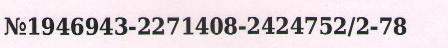

Распознано: 1946943-2271408-2424752/2-78



Распознано: 1946943-2271408-2424752/2-78



Распознано: 1



Распознано: 1946943-2271408-2424752/2-78



Распознано: 2



Распознано: 1946943-2271408-2424752/2-78



Распознано: 3



In [9]:
for im in sorted(list_names):
  image = cv2.imread(im)
  cv2_imshow(image)
  im_num = recognize_long_number(image)
  if len(im_num)<3:
    im_num = recognize_short_number(image)
  print("Распознано:", im_num)
  print()